# 09d: Sentiment EDA and Correlation with Energy Prices
This notebook explores the sentiment scores generated using DistilBERT and links them to temporal patterns and energy prices.

In [1]:
# Step 1: Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-muted')

In [2]:
# Step 2: Load sentiment-annotated news
sentiment_df = pd.read_csv('../data/processed/filtered_energy_news_with_sentiment.csv', parse_dates=['date'])

In [3]:
# Step 3: Convert to daily average sentiment
daily_sentiment = sentiment_df.groupby(sentiment_df['date'].dt.date).agg(
    avg_score=('sentiment_score', 'mean'),
    pos_ratio=('sentiment', lambda x: (x == 'POSITIVE').mean()),
    count=('sentiment', 'count')
).rename_axis('date').reset_index()
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
daily_sentiment.set_index('date', inplace=True)
daily_sentiment.tail()

,avg_score,pos_ratio,count
date,,,
2020-12-19,0.752109,0.000000,1
2020-12-21,0.984157,0.000000,3
2020-12-27,0.999665,0.500000,2
2020-12-29,0.991319,0.000000,2
2020-12-31,0.991236,0.333333,3


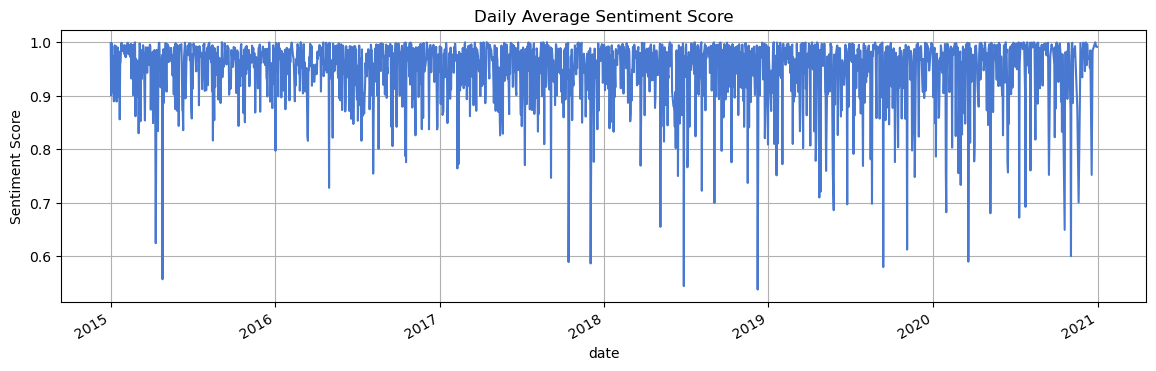

In [4]:
# Step 4: Plot daily average sentiment trends
plt.figure(figsize=(14, 4))
daily_sentiment['avg_score'].plot(title='Daily Average Sentiment Score')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()

In [6]:
# Step 5: Correlate with energy prices
# Load energy prices
price_df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])

# Ensure only numeric data is used in the resample (like energy price)
price_df = price_df.set_index('utc_timestamp')[['Price (EUR/MWhe)']]
price_df = price_df.resample('D').mean().rename(columns={'Price (EUR/MWhe)': 'daily_price'})

# Merge
combined = price_df.join(daily_sentiment, how='inner')
combined.dropna(inplace=True)
combined.tail()

,daily_price,avg_score,pos_ratio,count
2019-12-22,25.410833,0.988913,0.0,1
2019-12-23,24.749583,0.976306,0.0,2
2019-12-24,22.581250,0.946802,0.0,3
2019-12-29,28.939167,0.998454,0.0,2
2019-12-30,11.420000,0.995264,0.5,2


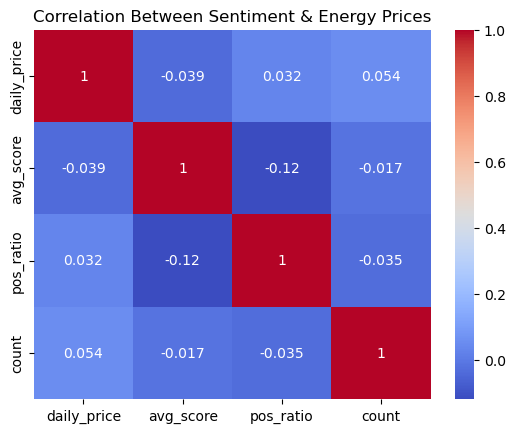

In [7]:
# Step 6: Correlation heatmap
sns.heatmap(combined.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Sentiment & Energy Prices")
plt.show()

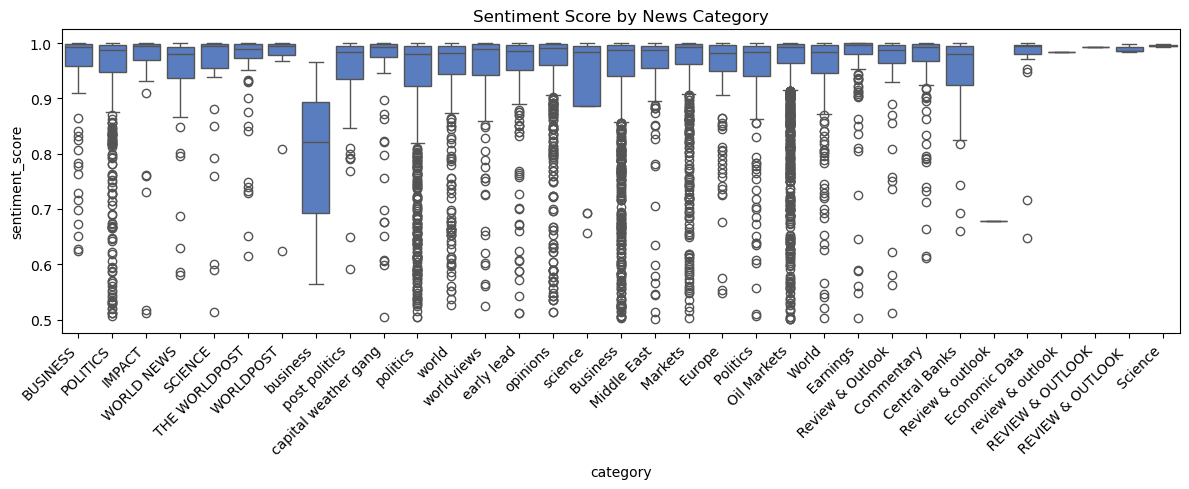

In [8]:
# Step 7: Sentiment by category
plt.figure(figsize=(12, 5))
sns.boxplot(data=sentiment_df, x='category', y='sentiment_score')
plt.xticks(rotation=45, ha='right')
plt.title('Sentiment Score by News Category')
plt.tight_layout()
plt.show()

📊 Correlation between energy prices and sentiment scores by category:


,category,corr_price_avg_score,corr_price_pos_ratio,sample_size
14,Middle East,0.265729,-0.101735,137
16,Europe,0.214049,0.080090,141
3,WORLD NEWS,0.138608,-0.099589,55
22,Commentary,0.084532,0.092198,124
11,early lead,0.076898,-0.042997,141
1,POLITICS,0.065904,0.051560,456
17,Politics,0.046538,-0.030561,137
15,Markets,0.044697,0.029397,518
5,THE WORLDPOST,0.015580,0.126961,75
12,opinions,0.014595,-0.013477,385


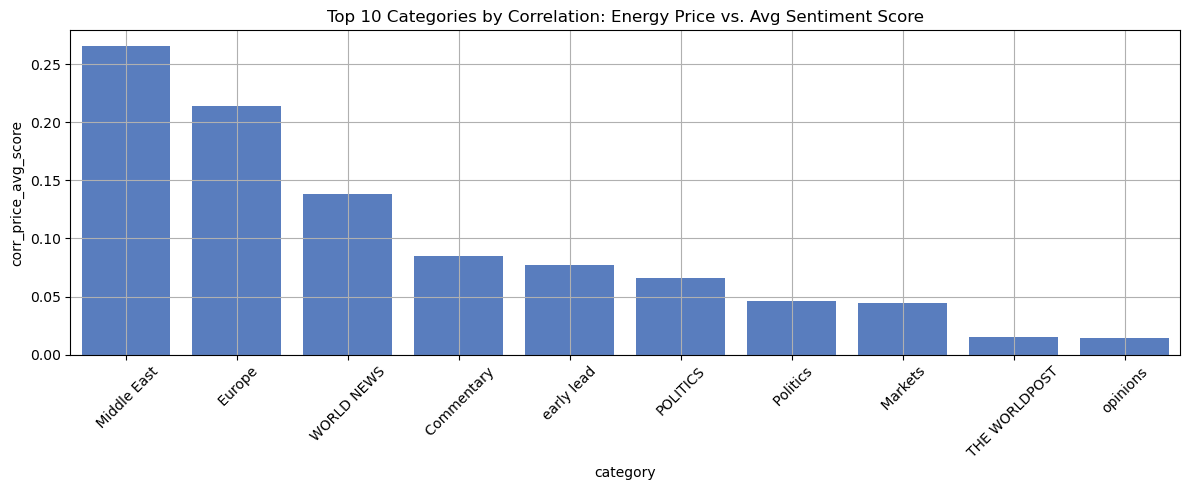

In [9]:
# Step 8: Correlation by category (price vs sentiment)

# Merge daily prices again to ensure alignment
price_df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
price_df = price_df.set_index('utc_timestamp')[['Price (EUR/MWhe)']]
price_df = price_df.resample('D').mean().rename(columns={'Price (EUR/MWhe)': 'daily_price'})

# Prepare result container
results = []

# Loop through each category
for category in sentiment_df['category'].unique():
    cat_df = sentiment_df[sentiment_df['category'] == category].copy()
    daily_cat = cat_df.groupby(cat_df['date'].dt.date).agg(
        avg_score=('sentiment_score', 'mean'),
        pos_ratio=('sentiment', lambda x: (x == 'POSITIVE').mean())
    ).rename_axis('date').reset_index()
    daily_cat['date'] = pd.to_datetime(daily_cat['date'])
    daily_cat.set_index('date', inplace=True)

    # Merge with price data
    merged = price_df.join(daily_cat, how='inner').dropna()

    if len(merged) > 30:  # Only keep categories with enough data
        results.append({
            'category': category,
            'corr_price_avg_score': merged['daily_price'].corr(merged['avg_score']),
            'corr_price_pos_ratio': merged['daily_price'].corr(merged['pos_ratio']),
            'sample_size': len(merged)
        })

# Create results DataFrame
correlation_df = pd.DataFrame(results).sort_values(by='corr_price_avg_score', ascending=False)

# Display
print("📊 Correlation between energy prices and sentiment scores by category:")
display(correlation_df)

# Optional: Plot top correlations
plt.figure(figsize=(12, 5))
sns.barplot(data=correlation_df.head(10), x='category', y='corr_price_avg_score')
plt.title("Top 10 Categories by Correlation: Energy Price vs. Avg Sentiment Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
# Show unique categories in the current sentiment file
print("📋 Unique categories in sentiment dataset:")
print(sorted(sentiment_df['category'].unique()))

📋 Unique categories in sentiment dataset:
[' Business', ' Central Banks', ' Commentary', ' Earnings', ' Economic Data', ' Europe', ' Markets', ' Middle East', ' Oil Markets', ' Politics', ' REVIEW & OUTLOOK', ' REVIEW & OUTLOOK ', ' Review & Outlook', ' Review & outlook', ' Science', ' World', ' review & outlook', 'BUSINESS', 'IMPACT', 'POLITICS', 'SCIENCE', 'THE WORLDPOST', 'WORLD NEWS', 'WORLDPOST', 'business', 'capital weather gang', 'early lead', 'opinions', 'politics', 'post politics', 'science', 'world', 'worldviews']


In [9]:
import pandas as pd

# Load sentiment data
sentiment_df = pd.read_csv('../data/processed/filtered_energy_news_with_sentiment.csv', parse_dates=['date'])

# Strip whitespace and lowercase all category names for consistency
sentiment_df['category'] = sentiment_df['category'].str.strip().str.lower()

# Define top categories (normalized)
top_categories = [
    'middle east', 'europe', 'central banks',
    'impact', 'science'
]

# Filter
filtered_sentiment_df = sentiment_df[sentiment_df['category'].isin(top_categories)]

# Save
filtered_sentiment_df.to_csv('../data/processed/final_sentiment_filtered_news.csv', index=False)
print('✅ Filtered and saved top-category sentiment data to /data/processed/final_sentiment_filtered_news.csv')

# Show category counts
print("\nFiltered category distribution:")
print(filtered_sentiment_df['category'].value_counts())


✅ Filtered and saved top-category sentiment data to /data/processed/final_sentiment_filtered_news.csv

Filtered category distribution:
category
middle east      166
europe           163
science           50
central banks     44
impact            43
Name: count, dtype: int64
